In [1]:
import os
import copy

import pandas as pd
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


class Experiment:
    d: pd.DataFrame = None
    folder = None
    name = None

    def __init__(self, data=None, name=''):
        self.d = data
        self.name = name
        self.log = []
        self.info = {}

    def set_info(self, **info):
        self.info.update(info)

    def log_wrapp(func):

        def log_wrapper(self, *args, **kwargs):
            res = func(self, *args, **kwargs)
            self.log.append(res)
            return self.d

        return log_wrapper

    @log_wrapp
    def load_csv(self, path=''):
        path, self.folder, self.name = self._input_path(path)
        self.d = pd.read_csv(path)
        self.d.rename(columns={'Temperature': 'x', 'Viscosity': 'y'}, inplace=True)
        return ('csv loaded', path)

    @log_wrapp
    def load_hdf5(self, path=''):
        path, self.folder, self.name = self._input_path(path)

        with pd.HDFStore(path) as file:
            self.d = file['data']
            self.info.update(file.get_storer('data').attrs.info)
            self.log.extend(file.get_storer('data').attrs.log)
        return ('hdf5 loaded', path)

    def save_hdf5(self):
        file_path = f'{self.folder}\{self.name}.hdf5'
        with pd.HDFStore(file_path) as file:
            file.put('data', self.d)
            file.get_storer('data').attrs.log = self.log
            file.get_storer('data').attrs.info = self.info

    def copy(self):
        return copy.deepcopy(self)

    @staticmethod
    def _input_path(path):
        while (path == '') or (not os.path.isfile(path)):
            path = input(f"Input data path: ")
        path_list = (path).split('\\')
        folder = '\\'.join(path_list[:-1])
        name = path_list[-1].split('.')[0]
        return path, folder, name

    @log_wrapp
    def apply(self, func):
        self.d['time'], self.d['x'], self.d['y'] = func(self.d['time'], self.d['x'], self.d['y'])
        return (func.__name__, [])

    @log_wrapp
    def group_filter(self, filter, by='x', column='y'):
        group = self.d.groupby(by=by)[column]
        mask = group.apply(filter).droplevel([0]).sort_index().to_numpy()
        self.d = self.d[mask]
        return (filter.__name__, [])

    @log_wrapp
    def mask_filter(self, filter, **kwargs):
        self.d = filter(self.d, **kwargs)
        return (filter.__name__, kwargs)

In [6]:
## Functions
def nu_D(time, x, y):
    # k = 1.380649 * 1e-23
    k = 1
    y = k * x / (y*0.001)
    return time, x, y


def nu_to_v(time, x, y):
    ro = 1.73
    y = y / ro
    return time, x, y


def K_to_C(time, x, y):
    x = x - 273.15
    return time, x, y


def C_to_K(time, x, y):
    x = x + 273.15
    return time, x, y


def linearize(time, x, y):
    x = 1 / x
    y = np.log(y)
    return time, x, y


def delinearize(time, x, y):
    x = 1 / x
    y = np.exp(y)
    return time, x, y


## Mask filters
def initial_filter(df, x=(-np.inf, np.inf), y=(0, np.inf), time=(0, np.inf)):
    temperature_cond = ((x[0] < df['x']) & (df['x'] < x[1]))
    viscosity_cond = ((y[0] < df['y']) & (df['y'] < y[1]))
    time_cond = ((time[0] < df['time']) & (df['time'] < time[1]))
    return df[temperature_cond & viscosity_cond & time_cond]


## Group filters
def z_filter(data: pd.Series):
    mean = data.mean()
    s = data.std(ddof=0) + 1e-50
    z_score = np.abs((data-mean) / s) < 1
    return z_score


def whisker_iqr_filter(data: pd.Series):
    whisker_width = 0.5
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1 + 1e-50
    return (data >= q1 - whisker_width*iqr) & (data <= q3 + whisker_width*iqr)


def iqr_filter(data: pd.Series):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1 + 1e-50

    return np.abs((data - data.median()) / iqr) < 1



In [33]:
# OCM
ocm_list = []
for i in range(9):
    path = f'D:\WORKS\Diplom-work\Experiments\OCM_viscosity\OCM{i}'
    file = [f for f in os.listdir(path) if '.hdf5' in f][0]

    exp = Experiment()
    exp.load_hdf5(f'{path}\{file}')
    df = exp.d

    k = 1
    df['Viscosity'] = k * (df['x'] + 273.15) / (df['y'] * 0.001)
    df['compound'] = exp.info['compound']
    df['rho'] = exp.info['rho']
    df['w'] = exp.info['w']
    df['D0'] = exp.info['D0']
    # df['E'] = exp.info['E']
    df.rename(columns={'x': 'Temperature', 'y': 'D'}, inplace=True)

    ocm_list.append(df)
    
ocm = pd.concat(ocm_list)

In [39]:
# PETA
peta_list = []
for i in range(5):
    path = f'D:\WORKS\Diplom-work\Experiments\PETA,TMAG_viscosity\PETA{i}'
    file = [f for f in os.listdir(path) if '.hdf5' in f][0]

    exp = Experiment()
    exp.load_hdf5(f'{path}\{file}')
    df = exp.d

    k = 1
    df['Viscosity'] = k * (df['x'] + 273.15) / (df['y'] * 0.001)
    df['compound'] = exp.info['compound']
    df['rho'] = exp.info['rho']
    df['w'] = exp.info['w']
    df['D0'] = exp.info['D0']
    # df['E'] = exp.info['E']
    df.rename(columns={'x': 'Temperature', 'y': 'D'}, inplace=True)

    peta_list.append(df)
    
peta = pd.concat(peta_list)

In [41]:
all=pd.concat([ocm,peta])

In [42]:
all

,time,D,Viscosity_verbose,Temperature,Temperature_verbose,Viscosity,compound,rho,w,D0
0,1.0,831.980284,OK,13.8,OK,344.9,ocm,1.72,0.00,5.805356e+13
1,2.0,831.980284,OK,13.8,OK,344.9,ocm,1.72,0.00,5.805356e+13
2,3.0,831.980284,OK,13.8,OK,344.9,ocm,1.72,0.00,5.805356e+13
3,4.0,830.775912,image_sweep_check,13.8,OK,345.4,ocm,1.72,0.00,5.805356e+13
4,5.0,830.775912,image_sweep_check,13.8,OK,345.4,ocm,1.72,0.00,5.805356e+13
...,...,...,...,...,...,...,...,...,...,...
10224,11657.0,14930.952381,OK,40.4,OK,21.0,peta,1.11,19.76,8.236533e+11
10225,11658.0,14930.952381,OK,40.4,OK,21.0,peta,1.11,19.76,8.236533e+11
10226,11661.0,14930.952381,OK,40.4,OK,21.0,peta,1.11,19.76,8.236533e+11
10227,11662.0,14930.952381,OK,40.4,OK,21.0,peta,1.11,19.76,8.236533e+11


In [43]:
ocm.head()

,time,D,Viscosity_verbose,Temperature,Temperature_verbose,Viscosity,compound,rho,w,D0
0,1.0,831.980284,OK,13.8,OK,344.9,ocm,1.72,0.0,5.805356e+13
1,2.0,831.980284,OK,13.8,OK,344.9,ocm,1.72,0.0,5.805356e+13
2,3.0,831.980284,OK,13.8,OK,344.9,ocm,1.72,0.0,5.805356e+13
3,4.0,830.775912,image_sweep_check,13.8,OK,345.4,ocm,1.72,0.0,5.805356e+13
4,5.0,830.775912,image_sweep_check,13.8,OK,345.4,ocm,1.72,0.0,5.805356e+13


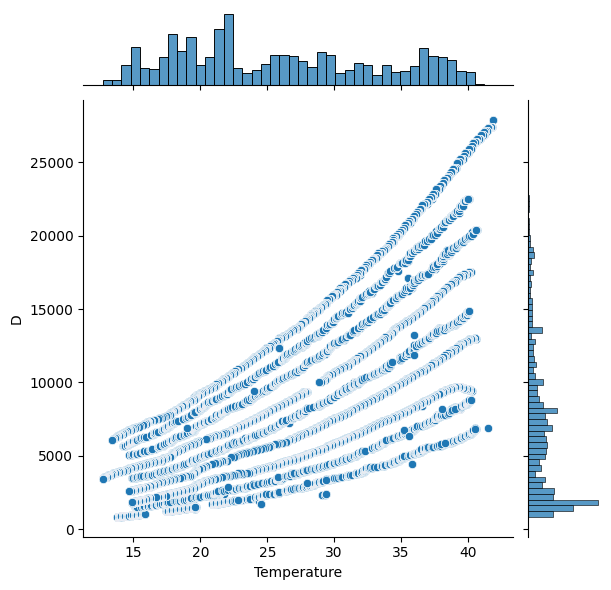

In [45]:
sns.jointplot(
    data=ocm,
    x='Temperature',
    y='D',
    
)